In [1]:
!pip3 install pysam
!pip3 install polars==0.20

In [2]:
from pysam import FastaFile
dna = FastaFile("../genome/AT_reference/GCF_000001735.4_TAIR10.1_genomic.fna")
print(dna.references)
chr_to_references = {
    "1": "CHR1",
    "2": "CHR2",
    "3": "CHR3",
    "4": "CHR4",
    "5": "CHR5",
}
a = dna.fetch(chr_to_references["1"], 0, 1000)

print(1,dna.get_reference_length(chr_to_references["1"]))
print(2,dna.get_reference_length(chr_to_references["2"]))
print(3,dna.get_reference_length(chr_to_references["3"]))
print(4,dna.get_reference_length(chr_to_references["4"]))
print(5,dna.get_reference_length(chr_to_references["5"]))


encode_dict = {
    "[mask]": 0,
    "A": 1,
    "C": 2,
    "G": 3,
    "T": 4,
    "Y": 5, # C or T
    "R": 6, # A or G
    "W": 7, # A or T
    "S": 8, # C or G
    "M": 9, # A or C
    "K": 10, # G or T
    "B": 11, # C or G or T
    "D": 12, # A or G or T
    "H": 13, # A or C or T
    "V": 14, # A or C or G
    "a": 1,
    "c": 2,
    "g": 3,
    "t": 4,
    "N": -1,
}

encode_bases = lambda bases: [encode_dict[base] for base in bases]



['CHR1', 'CHR2', 'CHR3', 'CHR4', 'CHR5', 'NC_037304.1', 'NC_000932.1']
1 30427671
2 19698289
3 23459830
4 18585056
5 26975502


In [3]:
import networkx as nx
import polars as pl

methylome_base_dir = "/mnt/fast/epigenomics/MA3_new_total_original_methylome/"

G = nx.DiGraph()

with open(methylome_base_dir + "nodelist.txt") as f:
    nodes = f.read().splitlines()

with open(methylome_base_dir + "edgelist.txt") as f:
    edges = f.read().splitlines()

for node in nodes: 

    if node == "filename,node,gen,meth" or node == "":
        continue

    
    filename, node, gen, meth = node.split(',')
    line = node.split('_')[1]
    
    node = {
        'filename': filename,
        'node': node,
        'line': int(line),
        'gen': int(gen),
        'meth': True if meth == 'Y' else False
    }

    
    G.add_node(node['node'], **node)

for edge in edges:

    if edge == "from to":
        continue

    from_, to_ = edge.split(" ")

    G.add_edge(from_, to_)


for (idx, node) in G.nodes(data=True):
    if node["filename"] != "-":
        df = pl.read_csv(node["filename"], separator="\t", ignore_errors=True).filter((pl.col("seqnames").is_not_nan()) & (pl.col("seqnames").is_not_null()) & (pl.col("context") == "CG")).rename({"seqnames": "chromosome"})
       # df = df.with_columns(pl.col("status").map_elements(lambda x: 0. if x == "U" else 0.5 if x == "I" else 1.).alias("status_numeric"))
        # display(df)
    node["sites"] = df

def get_predecessor_node(node):
    if not node in G:
        return None

    pred = iter(G.pred[node])

    if pred.__length_hint__() == 0:
        return None

    pred = G.nodes[next(pred)]

    if pred["meth"]:
        return pred
    else:
        return get_predecessor_node(pred['node'])

def get_pred_node_by_gen_and_line(gen, line):
    pred =  get_predecessor_node(f"{gen}_{line}")
    if pred is None:
        return None, None
    gen, line = pred["node"].split('_')
    return int(gen), int(line)



In [4]:
import numpy as np

embedding_by_chr = {}

for chrsm in range(1, 6):
    print(chrsm)
    data = pl.DataFrame({ "sequence": encode_bases(dna.fetch(chr_to_references[f"{chrsm}"]))})

    # turn coordinates like 13000-13600 into array like 111112222233333
    # genes are non-overlapping, allowing us to store it in a single array
    genes = np.zeros(data.height, dtype=np.int8)
    for (i, g) in  enumerate(["gbM", "teM", "UM"]):
        df = pl.read_csv(f"/mnt/fast/epigenomics/genes/{g}_gene_anotation_extract_Arabidopsis.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end", "name", "type", "strand"])
        # turn coordinates like 13000-13600 into bitarray like 000001111111100000
        for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
            genes[row["start"]:row["end"]] = i + 1 if row["strand"] == "+" else -1 * (i + 1)

    genes = pl.Series(f"genes", genes)

    data = data.with_columns(genes)

    # turn coordinates like 13000-13600 into array like 111112222233333
    # chromatine states are non-overlapping, allowing us to store it in a single array
    chr_states = np.zeros(data.height, dtype=np.int8)
    for i in range(1,37):
        df = pl.read_csv(f"/mnt/fast/epigenomics/chr_states/At_segments_S{i}.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end", "state"])
        for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
            chr_states[row["start"]:row["end"]] = i + 1

    chr_states = pl.Series(f"Chromatine States", chr_states)
    
    data = data.with_columns(chr_states)

    for mod in ["h2az","H3","H3K27Me3","H3K36Me3","H3K4Me1","H3K4Me3","H3K56Ac"]:
        print(mod)
        df = pl.read_csv(f"/mnt/fast/epigenomics/modifications/final/{mod}.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end"])

        # turn coordinates like 13000-13600 into bitarray like 000001111111100000
        a = np.zeros(data.height, dtype=np.int8)

        for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
            a[row["start"]:row["end"]] = 1

        s = pl.Series(f"{mod}", a)

        data = data.with_columns(s)
       
    embedding_by_chr[chrsm] = data


1


h2az
H3
H3K27Me3
H3K36Me3
H3K4Me1
H3K4Me3
H3K56Ac
2
h2az
H3
H3K27Me3
H3K36Me3
H3K4Me1
H3K4Me3
H3K56Ac
3
h2az
H3
H3K27Me3
H3K36Me3
H3K4Me1
H3K4Me3
H3K56Ac
4
h2az
H3
H3K27Me3
H3K36Me3
H3K4Me1
H3K4Me3
H3K56Ac
5
h2az
H3
H3K27Me3
H3K36Me3
H3K4Me1
H3K4Me3
H3K56Ac


In [5]:
for (chrsm, embedding) in embedding_by_chr.items():
    embedding.write_parquet(f"./embeddings/chr_{chrsm}.parquet")

In [6]:
def steady_state(alpha: float, beta: float):
    pi1 = lambda a, b:  (a * ((1.0 - a) ** 2  - (1.0 - b)**(2) - 1.0)) / ((a + b) * ((a + b - 1.0)**(2) - 2.0))
    pi2 = lambda a, b:  (4.0 * a * b * (a + b - 2.0)) / ((a + b) * ((a + b - 1.0)**(2) - 2.0));
    
    return pi1(alpha, beta) + 0.5 * pi2(alpha, beta)



In [40]:
import os
import subprocess
import shutil




def alphabeta(pedigree: nx.DiGraph, sites = 512, offset = 0): 
    """
    Run alphabeta-rs to calculate inheritance rates for all slices of a specified size in the genome.
    """

    edgelist = "from,to\n"
    edgelist+= "\n".join([f"{edge[0]},{edge[1]}" for edge in pedigree.edges])

    slices = []

    for (_, node) in pedigree.nodes(data=True):
        if node["meth"]:
            df : pl.DataFrame = node["sites"]
            dfs = df.filter(pl.col("context") == "CG").partition_by("chromosome", as_dict=True)
            for (chrsm, df) in dfs.items():
                for offset_idx in range(sites // offset if offset > 0 else 1):
                    off = offset_idx * offset
                    offset_df = df[off:]
                    for (i, s) in enumerate(offset_df.iter_slices(n_rows=sites)):

                        start = s.get_column("start").min()
                        end = s.get_column("start").max()
                        
                        dir = f"./slices/{sites}_{offset}/chr:{chrsm}_{start}-{end}"
                        dir = os.path.abspath(dir)

                        if node["node"] == "0_0": # Setup when running for the first time
                            if os.path.exists(dir):
                                shutil.rmtree(dir)
                            os.makedirs(dir)

                            nodelist = "filename,node,gen,meth\n"
                            nodelist += "\n".join([(f"{dir}/{node['node']}.bed" if node['meth'] else "-") + f",{node['node']},{node['gen']},{'Y' if node['meth'] else 'N'}" for (_,node) in pedigree.nodes(data=True)])
                            
                            open(f"{dir}/nodelist.txt", "w").write(nodelist)
                            open(f"{dir}/edgelist.txt", "w").write(edgelist)

                            # if end-start > 1000:
                            #     print(f"Sites between {chrsm}:{start}-{end} are far-away from each other ({end-start} bp)." )
                            slices.append((chrsm, i, start, end))

                        s.write_csv(f"{dir}/{node['node']}.bed", separator="\t")
                        
                        
                        
                        
                        

    slices = pl.DataFrame(slices, schema=["chrsm", "slice", "start", "end"])
    display(slices.sort("chrsm", "start"))
    results = []
    num_files = len(os.listdir(f"./slices/{sites}_{offset}"))

    for (i, slc) in enumerate(os.listdir(f"./slices/{sites}_{offset}")):
        try: 
            dir = os.path.abspath(f"./slices/{sites}_{offset}/{slc}")
    
            if i % 100 == 0:
                print(f"{i+1}/{num_files}")
            res = subprocess.run(["alphabeta", "-n" ,f"{dir}/nodelist.txt", "-e", f"{dir}/edgelist.txt", "-o", f"{dir}", "-i", "10" ], capture_output=True)

            model = pl.read_csv(f"{dir}/analysis.txt", separator="\t", has_header=False, new_columns=["key", "value"], ignore_errors=True)
            alpha = model.filter(pl.col("key") == "Alpha").get_column("value").max()
            beta = model.filter(pl.col("key") == "Beta").get_column("value").max()
            for l in res.stdout.decode("utf-8").splitlines():
                if l.startswith("Observed steady state methylation"):
                    std_st = float(l.removeprefix("Observed steady state methylation "))
                    break

            # shutil.rmtree(dir)
            results.append((alpha, beta, std_st))
        except Exception as e:
            print(e)
            print(f"Failed to run alphabeta-rs for {dir}")
            print("Output of alphabeta-rs:")
            res = subprocess.run(["alphabeta", "-n" ,f"{dir}/nodelist.txt", "-e", f"{dir}/edgelist.txt", "-o", f"{dir}", "-i", "10" ], capture_output=True)
            print(res.stdout.decode("utf-8"))
            print(res.stderr.decode("utf-8"))
            results.append((0., 0., 0.))
            continue

    results = pl.DataFrame(results, schema=["alpha", "beta", "std_st"])
    
    results = slices.hstack(results)
    display(results)
    results.write_parquet(f"./alphabeta_{sites}_{offset}.parquet")
    return results




In [41]:
meth_rates = alphabeta(G, sites=2**16, offset=2**12)

chrsm,slice,start,end
i64,i64,i64,i64
1,0,109,1264403
1,0,84741,1350625
1,0,155868,1436066
1,0,223571,1516914
1,0,306198,1598019
1,0,373954,1683895
1,0,457316,1767372
1,0,534164,1857451
1,0,607247,1945202


1/1361
101/1361
201/1361
301/1361
401/1361
501/1361
601/1361
701/1361
801/1361
901/1361
1001/1361
1101/1361
1201/1361
1301/1361


chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,str,str,f64
1,0,109,1264403,"""0.000223303497…","""0.001706261181…",0.116518
1,1,1264412,2585081,"""0.000272828005…","""0.002164070608…",0.112921
1,2,2585150,3990644,"""0.000200282644…","""0.001940563426…",0.094279
1,3,3990658,5381055,"""0.000218442633…","""0.001819834460…",0.10795
1,4,5381092,6750879,"""0.000397013891…","""0.000563924309…",0.414086
1,5,6750905,8097533,"""0.000240756273…","""0.001601875386…",0.131494
1,6,8097535,9516107,"""0.000164006175…","""0.002312833439…",0.066827
1,7,9516115,10988710,"""0.000219811876…","""0.002232373663…",0.090436
1,8,10988715,12434196,"""0.000377132818…","""0.000320754569…",0.541092


chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,f64,f64,f64
1,0,109,1264403,0.000223,0.001706,0.116518
1,0,84741,1350625,0.00021,0.002009,0.095382
1,0,155868,1436066,0.000204,0.00169,0.108577
1,0,223571,1516914,0.000361,0.000124,0.745267
1,0,306198,1598019,0.000176,0.002186,0.074999
1,0,373954,1683895,0.000193,0.001986,0.089472
1,0,457316,1767372,0.000204,0.002366,0.080282
1,0,534164,1857451,0.000265,0.002125,0.111621
1,0,607247,1945202,0.000351,0.000474,0.426224


shape: (1, 7)
┌───────┬──────────┬──────────┬──────────┬──────────┬─────────┬────────┐
│ chrsm ┆ slice    ┆ start    ┆ end      ┆ alpha    ┆ beta    ┆ std_st │
│ ---   ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---     ┆ ---    │
│ f64   ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64     ┆ f64    │
╞═══════╪══════════╪══════════╪══════════╪══════════╪═════════╪════════╡
│ 1.0   ┆ 10.16129 ┆ 1.5050e7 ┆ 1.6450e7 ┆ 0.000246 ┆ 0.00159 ┆ 0.2067 │
└───────┴──────────┴──────────┴──────────┴──────────┴─────────┴────────┘


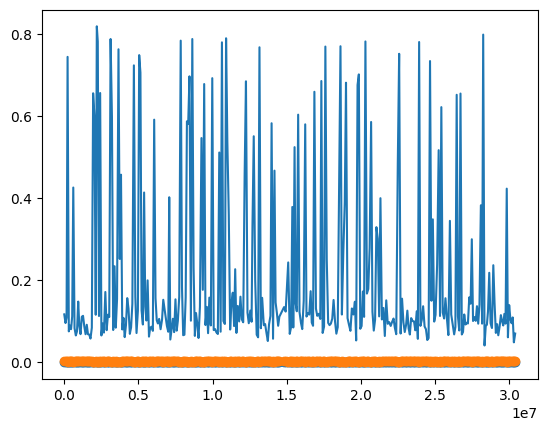

In [52]:
in_order = meth_rates.sort("chrsm", "start").cast({"alpha" : pl.Float64, "beta" : pl.Float64})
display(in_order)
import matplotlib.pyplot as plt
in_order.write_parquet("test.parquet")

in_order= in_order.filter(pl.col("chrsm") == 1)
plt.scatter(in_order["start"], in_order["alpha"])
plt.scatter(in_order["start"], in_order["beta"])
plt.plot(in_order["start"], in_order["std_st"])
print(in_order.mean())


In [15]:
# meth_rates = alphabeta(G, sites=512, offset=64)

1 0 109 13847
1 1 14028 25710
1 2 25773 37623
1 3 37633 49293
1 4 49298 58021
1 5 58023 67408
1 6 67422 76161
1 7 76167 84725
1 8 84741 95899
1 9 95905 105721
1 10 105767 114336
1 11 114342 120503
1 12 120510 129789
1 13 129818 138955
1 14 138996 149369
1 15 149380 155850
1 16 155868 164677
1 17 164723 172794
1 18 172821 182382
1 19 182403 189706
1 20 189766 199437
1 21 199445 207490
1 22 207514 216707
1 23 216723 223527
1 24 223571 232570
1 25 232588 243479
1 26 243561 257194
1 27 257202 266847
1 28 266911 274665
1 29 274689 285717
1 30 285786 297015
1 31 297016 306196
1 32 306198 312513
1 33 312518 322494
1 34 322512 332558
1 35 332625 341379
1 36 341387 349273
1 37 349301 358212
1 38 358214 366164
1 39 366169 373910
1 40 373954 388473
1 41 388604 396107
1 42 396155 408304
1 43 408306 415381
1 44 415390 425005
1 45 425027 435025
1 46 435239 445463
1 47 445563 457301
1 48 457316 466315
1 49 466397 475300
1 50 475389 485199
1 51 485242 494098
1 52 494119 506126
1 53 506128 518404
1 54 

KeyboardInterrupt: 

In [1]:
display(meth_rates)

NameError: name 'meth_rates' is not defined

In [ ]:
# meth_rates = alphabeta(G, 2**15)

In [ ]:
# alphabeta(G, 2**12)


In [ ]:
# meth_rates =alphabeta(G, 2**9)

In [ ]:
# meth_rates = alphabeta(G, 2 **6)

1/86998
No such file or directory (os error 2): /mnt/fast/epigenomics/conschti/slices/64/chr:1_11027/analysis.txt
Failed to run alphabeta-rs for /mnt/fast/epigenomics/conschti/slices/64/chr:1_11027
Output of alphabeta-rs:
Using default file: /mnt/fast/epigenomics/conschti/slices/64/chr:1_11027/nodelist.txt
Using default file: /mnt/fast/epigenomics/conschti/slices/64/chr:1_11027/edgelist.txt
Using default output directory: /mnt/fast/epigenomics/conschti/slices/64/chr:1_11027
Building pedigree...

thread 'main' panicked at /home/cgoeldel/.cargo/registry/src/index.crates.io-6f17d22bba15001f/alphabeta-0.2.1/src/ab_neutral.rs:28:41:
called `Option::unwrap()` on a `None` value
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace

101/86998
No such file or directory (os error 2): /mnt/fast/epigenomics/conschti/slices/64/chr:1_13221/analysis.txt
Failed to run alphabeta-rs for /mnt/fast/epigenomics/conschti/slices/64/chr:1_13221
Output of alphabeta-rs:
Using default fil

In [ ]:
def meth_rates_to_labels(dna, meth_rates: pl.DataFrame):
   

    labels_by_chrsm = {}
    for (chrsm, rates) in meth_rates.partition_by("chrsm", as_dict=True).items():
        print(chrsm, rates.height)
        sequence = pl.DataFrame({ "sequence": encode_bases(dna.fetch(chr_to_references[f"{chrsm}"]))})
        a = np.zeros(sequence.height, dtype=np.float32)
        b = np.zeros(sequence.height, dtype=np.float32)
        std_st = np.zeros(sequence.height, dtype=np.float32)
        for row in rates.iter_rows(named=True):
            
            a[row["start"]:row["end"]] = row["alpha"]
            b[row["start"]:row["end"]] = row["beta"]
            std_st[row["start"]:row["end"]] = row["std_st"]

        labels = sequence.with_columns(pl.Series("alpha", a), pl.Series("beta", b), pl.Series("std_st", std_st))
        display(labels[105:120])

        labels = labels.with_columns(pl.when(pl.col("sequence") == 1).then(pl.col("alpha")).otherwise(pl.lit(0.)).alias("alpha"))
        labels = labels.with_columns(pl.when(pl.col("sequence") == 2).then(pl.col("beta")).otherwise(pl.lit(0.)).alias("beta"))
        labels = labels.with_columns(pl.when(pl.col("sequence") == 3).then(pl.col("std_st")).otherwise(pl.lit(0.)).alias("std_st"))

        labels_by_chrsm[chrsm] = labels

    return labels_by_chrsm




In [ ]:
labels_by_chrms = meth_rates_to_labels(dna, meth_rates)


1 21793


sequence,alpha,beta,std_st
i64,f32,f32,f32
1,0.0,0.0,0.0
2,0.0,0.0,0.0
2,0.0,0.0,0.0
2,0.0,0.0,0.0
3,-5.4449e-10,-2.4406e-7,0.002226
1,-5.4449e-10,-2.4406e-7,0.002226
1,-5.4449e-10,-2.4406e-7,0.002226
1,-5.4449e-10,-2.4406e-7,0.002226
2,-5.4449e-10,-2.4406e-7,0.002226


2 14300


sequence,alpha,beta,std_st
i64,f32,f32,f32
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0


3 17470


sequence,alpha,beta,std_st
i64,f32,f32,f32
1,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
2,0.0,0.0,0.0
2,0.0,0.0,0.0
4,0.0,0.0,0.0
1,0.0,0.0,0.0
1,0.0,0.0,0.0
1,0.0,0.0,0.0


4 13738


sequence,alpha,beta,std_st
i64,f32,f32,f32
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0
-1,0.0,0.0,0.0


5 19697


sequence,alpha,beta,std_st
i64,f32,f32,f32
4,-0.000474,-0.00008,0.856236
1,-0.000474,-0.00008,0.856236
1,-0.000474,-0.00008,0.856236
3,-0.000474,-0.00008,0.856236
4,-0.000474,-0.00008,0.856236
3,-0.000474,-0.00008,0.856236
4,-0.000474,-0.00008,0.856236
4,-0.000474,-0.00008,0.856236
4,-0.000474,-0.00008,0.856236


In [ ]:

# print(embedding_by_chr.items())
display(labels_by_chrms[1][105:120])
display(embedding_by_chr[1])



sequence,alpha,beta,std_st
i64,f32,f32,f32
1,0.0,0.0,0.0
2,0.0,0.0,0.0
2,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.002226
1,-5.4449e-10,0.0,0.0
1,-5.4449e-10,0.0,0.0
1,-5.4449e-10,0.0,0.0
2,0.0,-2.4406e-7,0.0


sequence,gbM,teM,UM,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,h2az,H3,H3K27Me3,H3K36Me3,H3K4Me1,H3K4Me3,H3K56Ac,input
i64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0


In [ ]:
for (chrsm, label) in labels_by_chrms.items():
    label.write_parquet(f"./lables/chr_{chrsm}.parquet")

FileNotFoundError: No such file or directory (os error 2)